In [1]:
import os
import argparse

import torch

import rlcard

from rlcard.agents import DQNAgent, RandomAgent
from rlcard.utils import (
    get_device,
    set_seed,
    tournament,
    reorganize,
    Logger,
    plot_curve,
)

import numpy as np

In [2]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: NVIDIA GeForce RTX 3060 Ti


In [3]:
# Initialize the Uno environment
env = rlcard.make('uno')

In [4]:
# The paths for saving the logs and learning curves
log_dir = './experiments/uno_dqn_result/'

In [10]:
# Default parameters for Deep-Q learning Agent
replay_memory_size = 5000
epsilon_decay_steps = 10000
learning_rate = 0.0005
batch_size = 32

# Adjusting parameters to see how it affects the learning curve
replay_memory_size = replay_memory_size * 2
epsilon_decay_steps = epsilon_decay_steps
learning_rate = learning_rate / 10
batch_size = batch_size * 2

In [11]:
agent = DQNAgent(
                 num_actions=env.num_actions,
                 state_shape=env.state_shape[0],
                 mlp_layers=[64,64],
                 replay_memory_size=replay_memory_size,
                 update_target_estimator_every=100,
                 epsilon_decay_steps=epsilon_decay_steps,
                 learning_rate=learning_rate,
                 batch_size=batch_size,
                 device=device,
                 save_path=log_dir,
                 )

In [12]:
# Set the number of players
num_players = 2

# Set the players in the environment
env.set_agents([agent] + [RandomAgent(env.num_actions) for _ in range(num_players - 1)])

# Reset the environment
state = env.reset()

## Training the Agent
To train the agent, you will need to create a training loop. During each iteration of the loop, the agent makes a decision, the environment is updated, and the agent learns from the result.

In [13]:
def adjust_rewards(trajectories, payoffs):
    adjusted_trajectories = []
    for traj in trajectories:
        adjusted_traj = []
        for state, action, reward, next_state, done in traj:
            # Actual game state details
            raw_obs = state['raw_obs']
            
            # Retrieve the number of cards in player's hand
            num_cards_player = len(raw_obs['hand'])
            
            # Provide the number of cards for each player with the current player being index 0
            num_cards_opponent = raw_obs['num_cards'][1] if raw_obs['current_player'] == 0 else raw_obs['num_cards'][0]

            if action == 60:  # Draw a card
                reward -= max(1, 3 - num_cards_player / 7)

            # Adjust rewards for action cards based on the opponent's hand size
            action_card_reward_multiplier = max(1, (7 - num_cards_opponent) / 7)

            if action in range(10, 15) or action in range(25, 30) or action in range(40, 45) or action in range(55, 60):
                reward += 2 * action_card_reward_multiplier

            # On top of the previous reward, add extra for playing action cards that makes the opponent draw cards
            if action in [12, 14, 27, 29, 42, 44, 57, 59]:
                reward += 2 * action_card_reward_multiplier

            # If there's only one card left in agent's hand, add big reward because it's very likely to win if it saves the wild card for the last
            if num_cards_player == 1 and action in [13, 14, 28, 29, 43, 44, 58, 59]:
                # However, we don't want to encourage the agent to save the wild card if the opponent has a small hand so we divide the reward
                reward += 25 / action_card_reward_multiplier

            # Smaller reward for playing normal cards, adjusted based on the number of cards in the player's hand
            if action in range(0, 10) or action in range(15, 25) or action in range(30, 40) or action in range(45, 55):
                reward += 1 + (3 - num_cards_player / 7)

            adjusted_traj.append((state, action, reward, next_state, done))
        adjusted_trajectories.append(adjusted_traj)
    return adjusted_trajectories

# Building out the simulation

Previously, the code would run an entire/complete simulation. However, this restricts the ability to learn from moves within the simulation.

In [14]:
episode_num = 25000  # Number of episodes 

evaluate_every = 1000 # Evaluate the agent every X episodes
evaluate_num = 100  # Number of games played in evaluation

with Logger(log_dir) as logger:
    for episode in range(episode_num):  # Number of episodes

        trajectories, payoffs = env.run(is_training=True)

        # Assuming 'payoffs' are the game outcomes for each player
        for i, payoff in enumerate(payoffs):
            if payoff > 0:  # Assuming a positive payoff means winning
                payoffs[i] = 100
            else:
                payoffs[i] = -75

        trajectories = reorganize(trajectories, payoffs)

        # After reorganizing the trajectories, adjust the rewards
        trajectories = adjust_rewards(trajectories, payoffs)
        # print(trajectories[0])

        for ts in trajectories[0]:
            agent.feed(ts)
        
        if episode % evaluate_every == 0:
                logger.log_performance(
                    episode,
                    tournament(
                        env,
                        evaluate_num,
                    )[0]
                )

    # Get the paths
    csv_path, fig_path = logger.csv_path, logger.fig_path


----------------------------------------
  episode      |  0
  reward       |  0.16
----------------------------------------
INFO - Step 100, rl-loss: 88.28986358642578
INFO - Copied model parameters to target network.
INFO - Step 200, rl-loss: 342.06890869140625
INFO - Copied model parameters to target network.
INFO - Step 300, rl-loss: 331.41149902343756
INFO - Copied model parameters to target network.
INFO - Step 400, rl-loss: 504.39825439453125
INFO - Copied model parameters to target network.
INFO - Step 500, rl-loss: 265.09780883789062
INFO - Copied model parameters to target network.
INFO - Step 600, rl-loss: 395.67660522460942
INFO - Copied model parameters to target network.
INFO - Step 700, rl-loss: 261.42703247070318
INFO - Copied model parameters to target network.
INFO - Step 800, rl-loss: 482.93713378906256
INFO - Copied model parameters to target network.
INFO - Step 900, rl-loss: 251.19085693359375
INFO - Copied model parameters to target network.
INFO - Step 1000, rl

## Evaluating the Agent
After training, evaluate your agent's performance. You can use RLCard's tournament function to play the game multiple times and see how well your agent performs:

Model saved in ./experiments/uno_dqn_result/model.pth


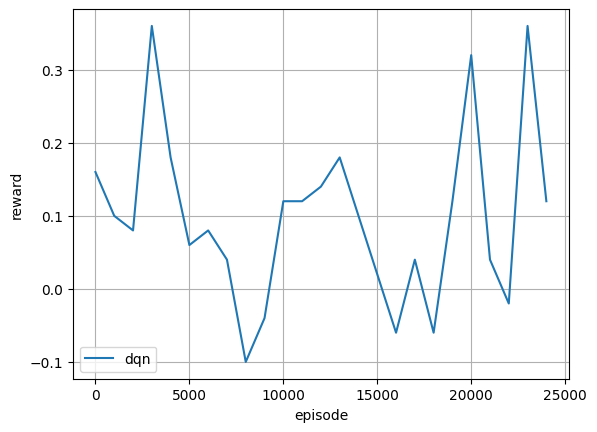

In [15]:
# Plot the learning curve
csv_path, fig_path = './experiments/uno_dqn_result/performance.csv', './experiments/uno_dqn_result/fig.png'
plot_curve(csv_path, fig_path, "dqn")

# Save model
save_path = os.path.join(log_dir, 'model.pth')
torch.save(agent, save_path)
print('Model saved in', save_path)